# 1. Set up environnement

## 1.1. Install gymnasium

In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"
!pip install gymnasium[all]
!pip install ale-py
!pip install stable_baselines3
!pip install pyvirtualdisplay

## 1.2. Import libraries

In [19]:
import imageio
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
from torchsummary import summary
from torchvision import transforms
from tqdm import tqdm
import os

## 1.3. Fix seed

In [2]:
def fix_all_seeds(seed, env=None):
    # Python random seed
    random.seed(seed)
    # NumPy random seed
    np.random.seed(seed)
    # PyTorch seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    if env is not None:
        env.action_space.seed(seed)
        env.observation_space.seed(seed)

# 2. Functions for Deep Q-learning

## Experience replay

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        states = np.array(states)
        next_states = np.array(next_states)
        weights = np.ones(batch_size)
        indices = np.ones(batch_size)
        return (
            torch.tensor(states, dtype=torch.float32).to(device),
            torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device),
            torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device),
            torch.tensor(next_states, dtype=torch.float32).to(device),
            torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device),
            torch.tensor(weights, dtype=torch.float32).unsqueeze(1).to(device),
            indices
        )

    def update_priorities(self, indices, td_errors):
        pass

    def __len__(self):
        return len(self.buffer)


In [4]:
class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        max_priority = max(self.priorities, default=1.0)
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
            self.priorities.append(max_priority)
        else:
            self.buffer[self.position] = (state, action, reward, next_state, done)
            self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities)
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        samples = [self.buffer[i] for i in indices]

        weights = (len(self.buffer) * probabilities[indices]) ** (-beta)
        weights /= weights.max()

        states, actions, rewards, next_states, dones = zip(*samples)
        return (
            torch.tensor(np.array(states), dtype=torch.float32).to(device),
            torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device),
            torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device),
            torch.tensor(np.array(next_states), dtype=torch.float32).to(device),
            torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device),
            torch.tensor(weights, dtype=torch.float32).unsqueeze(1).to(device),
            indices
        )

    def update_priorities(self, indices, td_errors):
        for i, error in zip(indices, td_errors):
            self.priorities[i] = abs(error.item()) + 1e-5


## MLP Network

In [5]:
class MLPQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(MLPQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

## CNN Network

In [6]:
class CNNQNetwork(nn.Module):
    def __init__(self, input_channels, action_dim):
        super(CNNQNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Calculer la taille de sortie après les convolutions
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, ROWS, COLS)
            self.flatten_size = self.conv(dummy_input).shape[1]
            
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),  # Sortie pour chaque action possible
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)


## Preprocessing frame

In [7]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((84, 84)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])


def stack_frames(frame, agent, is_new_episode):
    preprocessed_frame = transform(frame).squeeze()
    if is_new_episode:
        # Empile plusieurs fois la même frame si c'est la 1ère
        for _ in range(STACK_SIZE):
            agent.stacked_frames.append(preprocessed_frame)
    else:
        agent.stacked_frames.append(preprocessed_frame)

    return np.stack(agent.stacked_frames, axis=0)

## DQN-Agent

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size,network,buffer):
        self.state_size = state_size
        self.action_size = action_size
        self.qnetwork_policy = network(state_size, action_size).to(device)
        self.qnetwork_target = network(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_policy.parameters(), lr=LR)
        self.memory = buffer(MEMORY_SIZE)
        self.stacked_frames = deque(maxlen=STACK_SIZE)
        self.t_step = 0
        self.losses = []

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample(BATCH_SIZE)
            self.learn(experiences)

    def act(self, state, epsilon):
        if random.random() > epsilon:
            if TRAIN_FROM_FRAME:
                state = state.unsqueeze(0).clone().detach()
            with torch.no_grad():
                return self.qnetwork_policy(state).argmax().item()
        else:
            return random.choice(np.arange(self.action_size))

    def compute_loss(self, batch):
        states, actions, rewards, next_states, dones, weights, indices = batch

        # Current Q-values
        q_values = self.qnetwork_policy(states).gather(1, actions)

        # Target Q-values
        with torch.no_grad():
            next_actions = self.qnetwork_policy(next_states).argmax(1, keepdim=True)
            max_next_q_values = self.qnetwork_target(next_states).gather(1, next_actions)
            target_q_values = rewards + (1 - dones) * GAMMA * max_next_q_values

        # MSE loss
        td_errors = target_q_values - q_values
        loss = (weights * td_errors.pow(2)).mean()
        # loss = nn.MSELoss()(q_values, target_q_values)
        self.memory.update_priorities(indices, td_errors.abs())

        return loss

    def learn(self, experiences):
        loss = self.compute_loss(experiences)
        self.losses.append(loss.detach().item())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()    
        self.update(self.qnetwork_policy, self.qnetwork_target)
        

    def update(self, policy_net, target_net):
        if SOFT_UPDATE:
            for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
                target_param.data.copy_(TAU * policy_param.data + (1.0 - TAU) * target_param.data)
        else:
            if self.t_step % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())

## Train

In [9]:
def train_agent(env, agent, max_num_timesteps=1000):
    
    episode_rewards = []
    average_q_values = []
    losses = []
    moving_avg_rewards = []
    std_rewards = []
    episode_losses = []
    epsilon = EPSILON_START


    for episode in tqdm(range(NUM_EPISODES)):
        state, _ = env.reset()
        
        if TRAIN_FROM_FRAME:
            state = stack_frames(env.render(), agent, is_new_episode=True)

        state = torch.tensor(state, dtype=torch.float32).to(device)

        total_reward = 0

        for t in range(max_num_timesteps):
            action = agent.act(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            if TRAIN_FROM_FRAME:
                next_frame = env.render()
                next_frame = transform(next_frame).squeeze()
                next_state = stack_frames(next_frame,agent, is_new_episode=False)

            done = terminated or truncated
            agent.step(state.cpu().numpy(), action, reward, next_state, done)
            state = torch.tensor(next_state, dtype=torch.float32).to(device)
            total_reward += reward

            if done:
                break
        if len(agent.memory) > BATCH_SIZE:
            losses.append(np.mean(agent.losses))
            agent.losses = []
        episode_rewards.append(total_reward)

        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

        if len(episode_rewards) >= K:
            moving_avg = np.mean(episode_rewards[-K:])
            moving_avg_rewards.append(moving_avg)
            std_rewards.append(np.std(episode_rewards[-K:]))
            if moving_avg > SUCCESS_THRESHOLD:
                print(f"Environnement solved after {episode + 1} episode with an average reward of {moving_avg:.2f}")
                break
        else:
            moving_avg_rewards.append(np.nan)
            std_rewards.append(np.nan)

        with torch.no_grad():
            average_q = agent.qnetwork_policy(state.unsqueeze(0)).max(1)[0].mean().item()
            average_q_values.append(average_q)

        if (episode + 1) % (K) == 0:
            print(f"Episode {episode + 1}/{NUM_EPISODES}, Avg Reward (last {K}): {moving_avg:.2f}, Avg Q: {average_q:.2f}, Epsilon: {epsilon:.2f}")

    agent.memory.buffer.clear()
    env.close()
    return np.array(episode_rewards), np.array(std_rewards), np.array(moving_avg_rewards), np.array(average_q_values), np.array(losses)


## Test

In [22]:
def plot_results(episode_rewards,std_rewards,moving_avg_rewards,average_q_values, losses, path):

    if not os.path.exists(path): 
        os.makedirs(path) 
    
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards, label="Rewards per episode")
    plt.plot(moving_avg_rewards, label=f"Average rewards ({K} episodes)")
    plt.title("Rewards per episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.savefig(path + "rewards.png")

    plt.figure(figsize=(10, 5))
    plt.plot(moving_avg_rewards, label=f"Average rewards ({K} episodes)")
    plt.fill_between(
        range(len(moving_avg_rewards)),
        moving_avg_rewards - std_rewards,
        moving_avg_rewards + std_rewards,
        color="blue",
        alpha=0.2,
        label="standard deviation",
    )
    plt.title(f"Moving average rewards over {K} episodes")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.savefig(path + "avg_rewards.png")

    plt.figure(figsize=(10, 5))
    plt.plot(average_q_values)
    plt.title("Average Q-values")
    plt.xlabel("Episode")
    plt.ylabel("Q-value")
    plt.savefig(path + "Qvalues.png")

    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title("Losses")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.savefig(path + "loss.png")

    plt.show()


In [23]:
def test(agent,path, num_episodes = 100):
    
    if not os.path.exists(path): 
        os.makedirs(path) 

    episode_rewards = []

    for episode in tqdm(range(num_episodes)):
        state, _ = env.reset()
        
        if TRAIN_FROM_FRAME:
            frame = env.render()
            frame = transform(frame).squeeze()
            state = stack_frames(frame, agent, is_new_episode=True)
            
        state = torch.tensor(state, dtype=torch.float32).to(device)
        done = False
        total_reward = 0

        while not done:
            if TRAIN_FROM_FRAME:
                state = state.unsqueeze(0).clone().detach()
            with torch.no_grad():
                action = agent.qnetwork_policy(state).argmax().item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            if TRAIN_FROM_FRAME:
                next_frame = env.render()
                next_frame = transform(next_frame).squeeze()
                next_state = stack_frames(next_frame,agent, is_new_episode=False)

            done = terminated or truncated
            state = torch.tensor(next_state, dtype=torch.float32).to(device)
            total_reward += reward
            env.render()

        env.close()

        episode_rewards.append(total_reward)

    plt.plot(episode_rewards)
    plt.title("Test results")
    plt.xlabel("Episodes")
    plt.ylabel("Total reward")
    plt.savefig(path + "test.png")
    plt.show()
    print(episode_rewards)

### Save video 

In [12]:
def save_video(env, agent, filename):
    frames = []

    state, _ = env.reset()
    
    if TRAIN_FROM_FRAME:
            frame = env.render()
            frame = transform(frame).squeeze()
            state = stack_frames(frame, agent, is_new_episode=True)

    state = torch.tensor(state, dtype=torch.float32).to(device)
    done = False
    total_reward = 0

    while not done:
        if TRAIN_FROM_FRAME:
            state = state.unsqueeze(0).clone().detach()
        with torch.no_grad():
            action = agent.qnetwork_policy(state).argmax().item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        if TRAIN_FROM_FRAME:
                next_frame = env.render()
                next_frame = transform(next_frame).squeeze()
                next_state = stack_frames(next_frame,agent, is_new_episode=False)

        state = torch.tensor(next_state, dtype=torch.float32).to(device)
        
        frames.append(env.render())
        total_reward += reward

    env.close()
    print(total_reward)
    imageio.mimsave(filename, frames, fps=30)

# 3. Training of MLP model on Lunar Lander

In [13]:
# HYPERPARAMETERS
GAMMA = 0.99            # Facteur de discount
LR = 1e-3               # Taux d'apprentissage
BATCH_SIZE = 32         # Taille des lots pour l'entraînement
MEMORY_SIZE = 100000    # Taille du replay buffer
EPSILON_START = 1.0     # Valeur initiale pour epsilon (exploration)
EPSILON_END = 0.01      # Valeur finale pour epsilon
EPSILON_DECAY = 0.995   # Facteur de décroissance pour epsilon
TARGET_UPDATE = 10      # Fréquence de mise à jour du réseau cible
TAU = 0.1               # Taux de mise à jour du réseau cible
K = 100                 # Fenêtre pour calculer la moyenne des rewards
SUCCESS_THRESHOLD = 200 # Valeur de succès
NUM_EPISODES = 2000
TRAIN_FROM_FRAME = False
SOFT_UPDATE = True
STACK_SIZE = 4

In [14]:
# Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("LunarLander-v3", render_mode="rgb_array")
fix_all_seeds(42, env)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size, MLPQNetwork, ReplayBuffer)

# Training
rewards,std_rewards, avg_rewards, q_values, losses = train_agent(env, agent)

# Save model
torch.save(agent.qnetwork_policy.state_dict(), 'Models/policy_mlp_lunar_w_soft.pt')
torch.save(agent.qnetwork_target.state_dict(), 'Models/target_mlp_lunar_w_soft.pt')

  5%|▌         | 100/2000 [00:31<11:06,  2.85it/s]

Episode 100/2000, Avg Reward (last 100): -119.82, Avg Q: 5.65, Epsilon: 0.61


 10%|█         | 200/2000 [02:07<1:35:04,  3.17s/it]

Episode 200/2000, Avg Reward (last 100): -95.27, Avg Q: 67.88, Epsilon: 0.37


 15%|█▌        | 300/2000 [07:37<2:08:10,  4.52s/it]

Episode 300/2000, Avg Reward (last 100): -7.18, Avg Q: 42.93, Epsilon: 0.22


 20%|██        | 400/2000 [12:25<39:04,  1.47s/it]  

Episode 400/2000, Avg Reward (last 100): 105.80, Avg Q: 31.79, Epsilon: 0.13


 25%|██▌       | 500/2000 [15:06<48:20,  1.93s/it]  

Episode 500/2000, Avg Reward (last 100): 161.43, Avg Q: 35.10, Epsilon: 0.08


 28%|██▊       | 559/2000 [16:27<42:25,  1.77s/it]

Environnement solved after 560 episode with an average reward of 203.34


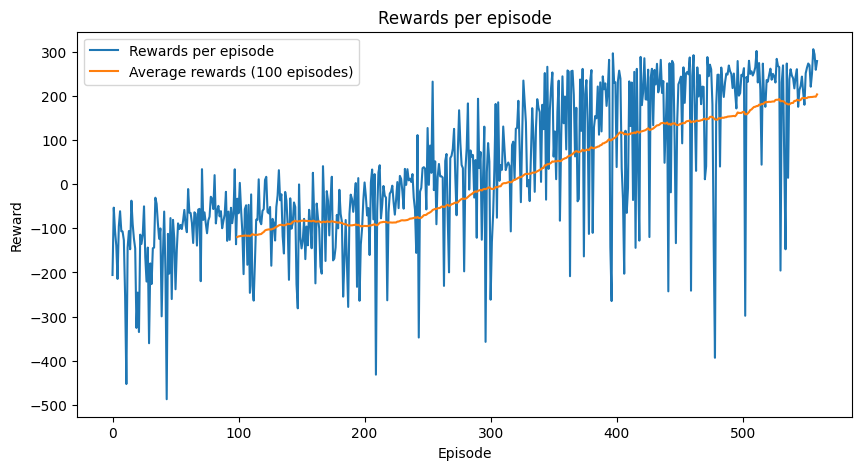

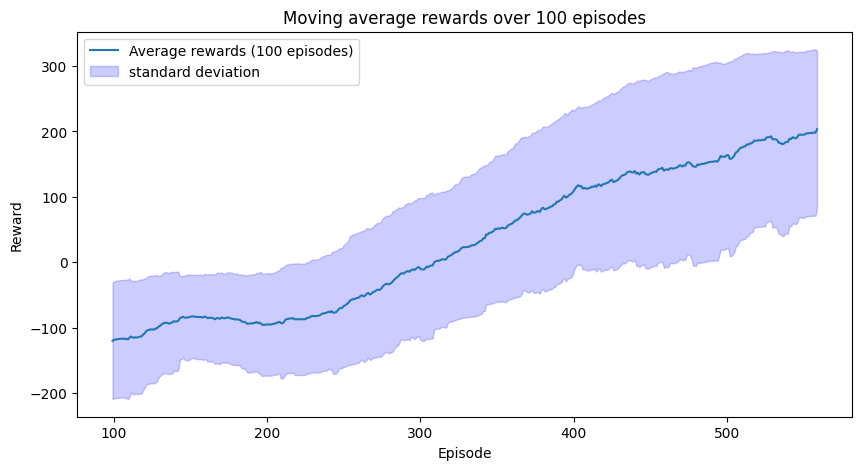

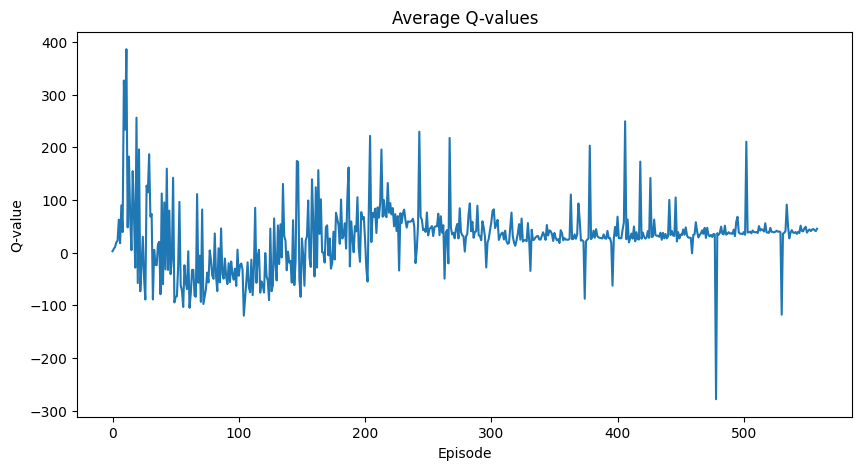

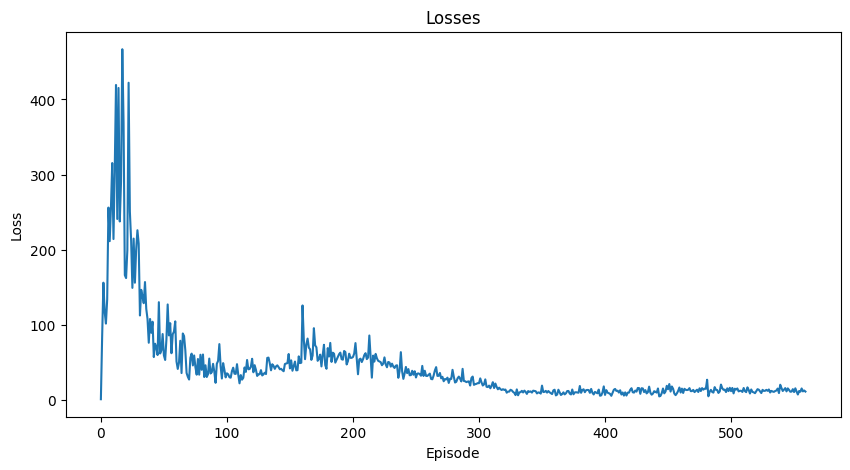

In [15]:
plot_results(rewards,std_rewards, avg_rewards, q_values, losses, "Plots/MLP_Lunar_w_soft/")

Test du modèle sur plusieurs épisodes

100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


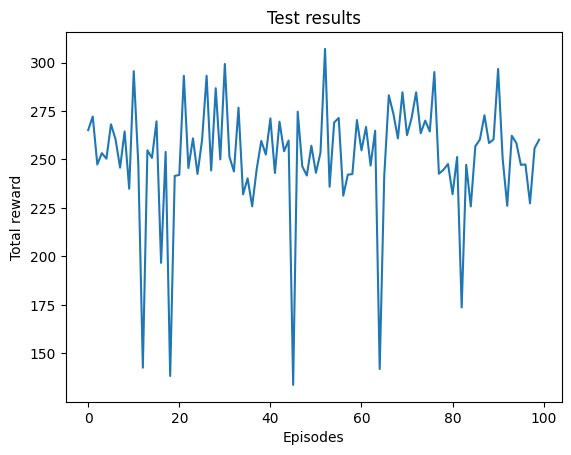

[np.float64(265.1581603647034), np.float64(272.14716777363685), np.float64(247.4030969989722), np.float64(253.25700069155207), np.float64(250.38773650268655), np.float64(268.12249719568587), np.float64(260.4170193533791), np.float64(245.77412436459713), np.float64(264.42534830223883), np.float64(234.89679567850348), np.float64(295.5419528240492), np.float64(247.80572608810914), np.float64(142.56998073509186), np.float64(254.71692095996806), np.float64(250.78078398106402), np.float64(269.6567963873452), np.float64(196.65486207538328), np.float64(253.89452968222827), np.float64(138.2929312111403), np.float64(241.5178096670233), np.float64(242.01063816494667), np.float64(293.1334794244761), np.float64(245.59151589146978), np.float64(260.86269076053566), np.float64(242.5126515338405), np.float64(260.04536168127356), np.float64(293.17164677351803), np.float64(244.31347078882618), np.float64(286.7510568757534), np.float64(250.02971099259642), np.float64(299.27711310921757), np.float64(251.47

In [16]:
test(agent,"Plots/MLP_Lunar_w_soft/")

In [17]:
save_video(env, agent, "Videos/LunarLander_MLP_w_soft.mp4")

248.48606606686963


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


# 4. Train MLP model on Lunar Lander (without soft update)

In [18]:
# HYPERPARAMETERS
GAMMA = 0.99            # Facteur de discount
LR = 1e-3               # Taux d'apprentissage
BATCH_SIZE = 32         # Taille des lots pour l'entraînement
MEMORY_SIZE = 100000    # Taille du replay buffer
EPSILON_START = 1.0     # Valeur initiale pour epsilon (exploration)
EPSILON_END = 0.01      # Valeur finale pour epsilon
EPSILON_DECAY = 0.995   # Facteur de décroissance pour epsilon
TARGET_UPDATE = 10      # Fréquence de mise à jour du réseau cible
TAU = 0.1               # Taux de mise à jour du réseau cible
K = 100                 # Fenêtre pour calculer la moyenne des rewards
SUCCESS_THRESHOLD = 200 # Valeur de succès
NUM_EPISODES = 2000
TRAIN_FROM_FRAME = False
SOFT_UPDATE = False
STACK_SIZE = 4

In [19]:
# Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("LunarLander-v3", render_mode="rgb_array")
fix_all_seeds(42, env)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size, MLPQNetwork, ReplayBuffer)

# Training
rewards,std_rewards, avg_rewards, q_values, losses = train_agent(env, agent)

# Save model
torch.save(agent.qnetwork_policy.state_dict(), 'Models/policy_mlp_lunar.pt')
torch.save(agent.qnetwork_target.state_dict(), 'Models/target_mlp_lunar.pt')

  5%|▌         | 100/2000 [00:34<13:53,  2.28it/s]

Episode 100/2000, Avg Reward (last 100): -116.21, Avg Q: 21.32, Epsilon: 0.61


 10%|█         | 200/2000 [02:24<1:38:35,  3.29s/it]

Episode 200/2000, Avg Reward (last 100): -95.88, Avg Q: 211.07, Epsilon: 0.37


 15%|█▌        | 300/2000 [07:45<2:06:07,  4.45s/it]

Episode 300/2000, Avg Reward (last 100): 15.63, Avg Q: 57.59, Epsilon: 0.22


 20%|██        | 400/2000 [12:06<50:05,  1.88s/it]  

Episode 400/2000, Avg Reward (last 100): 135.77, Avg Q: 33.70, Epsilon: 0.13


 25%|██▌       | 500/2000 [14:49<39:26,  1.58s/it]  

Episode 500/2000, Avg Reward (last 100): 174.59, Avg Q: 30.16, Epsilon: 0.08


 29%|██▉       | 585/2000 [17:00<41:08,  1.74s/it]

Environnement solved after 586 episode with an average reward of 200.16


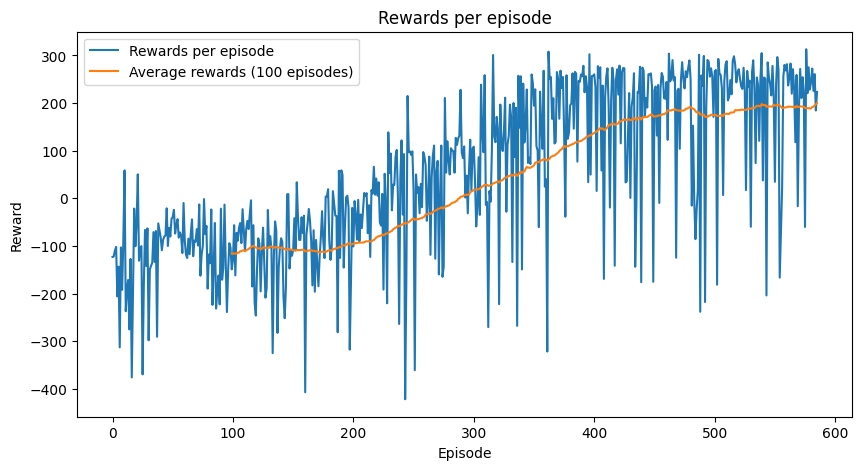

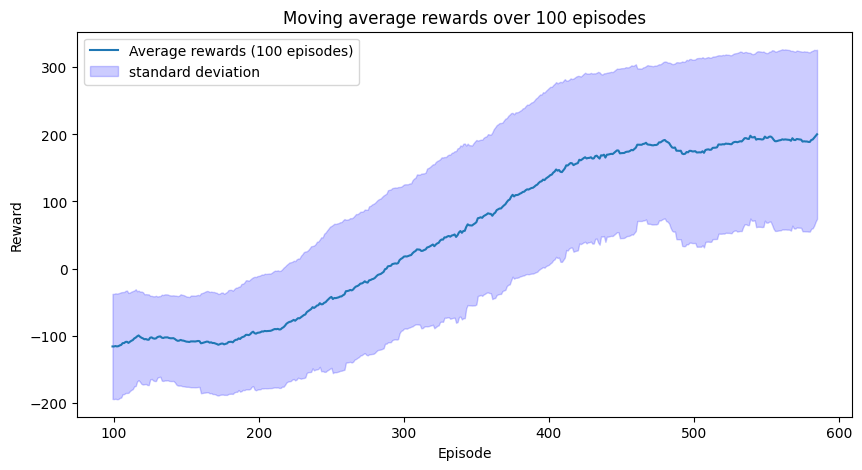

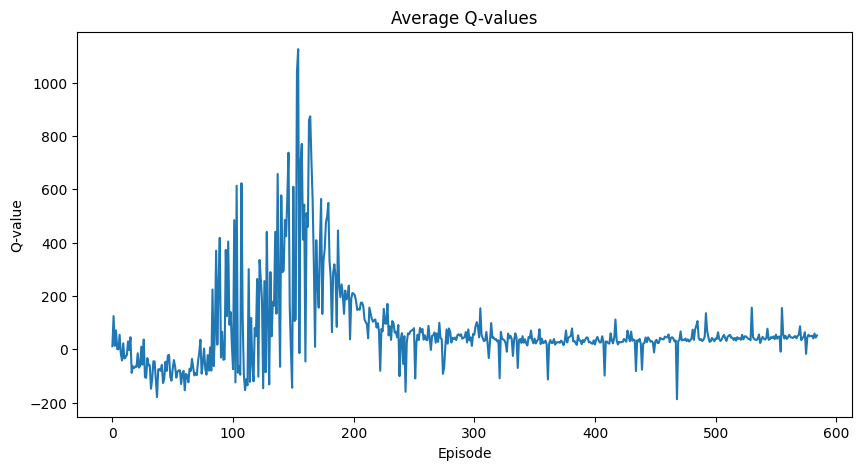

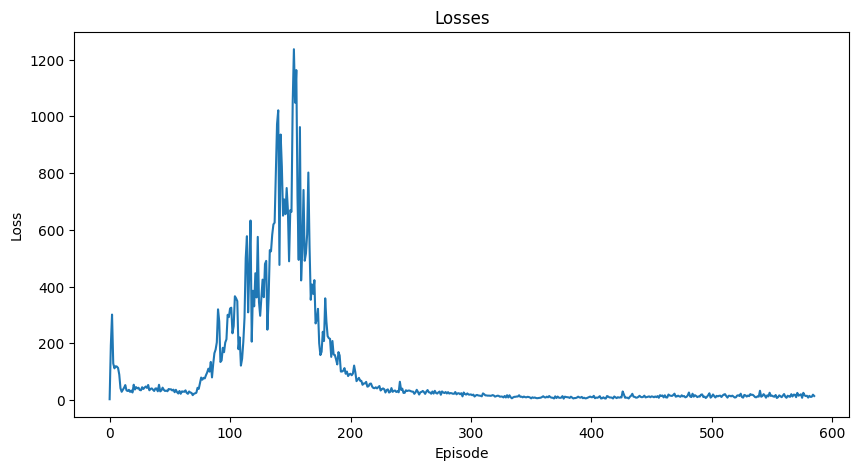

In [20]:
plot_results(rewards,std_rewards, avg_rewards, q_values, losses, "Plots/MLP_Lunar/")

100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


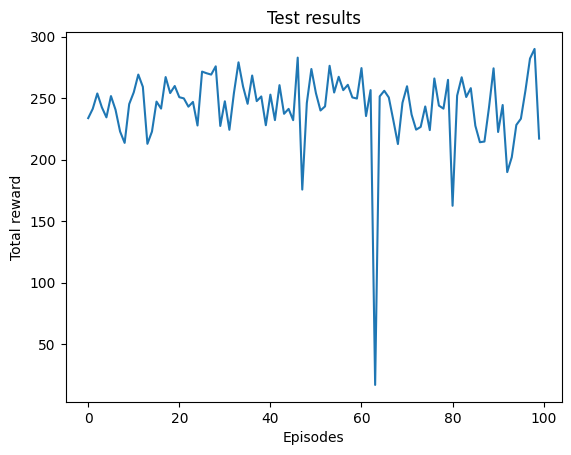

[np.float64(233.75531832419483), np.float64(241.326761782601), np.float64(253.77102300898534), np.float64(242.53000320614717), np.float64(234.38203035522506), np.float64(251.6549820753283), np.float64(240.55188054323318), np.float64(222.8908994679864), np.float64(213.6386272597397), np.float64(245.14916953401686), np.float64(254.67166458570873), np.float64(269.1250656071341), np.float64(259.1677311021358), np.float64(212.86988910475353), np.float64(222.80891172980597), np.float64(247.17380990475075), np.float64(241.48918253438256), np.float64(267.1123939052258), np.float64(254.10981766686962), np.float64(259.85010267424457), np.float64(250.75260831815623), np.float64(249.77415340457208), np.float64(243.06360232391262), np.float64(246.90825387340809), np.float64(227.76698434161665), np.float64(271.54645923569916), np.float64(270.2005647210744), np.float64(269.1142784471199), np.float64(275.8332985915464), np.float64(227.38538079940503), np.float64(247.44972498832848), np.float64(224.268

In [21]:
test(agent, "Plots/MLP_Lunar/")

In [22]:
save_video(env, agent, "Videos/LunarLander_MLP.mp4")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


217.95488999848982


# 5. Train CNN model on Frozen Lake (with prioritized experience replay)

In [13]:
# HYPERPARAMETERS
GAMMA = 0.95            # Facteur de discount
LR = 1e-4               # Taux d'apprentissage
BATCH_SIZE = 32         # Taille des lots pour l'entraînement
MEMORY_SIZE = 1000    # Taille du replay buffer
EPSILON_START = 1.0     # Valeur initiale pour epsilon (exploration)
EPSILON_END = 0.01      # Valeur finale pour epsilon
EPSILON_DECAY = 0.995   # Facteur de décroissance pour epsilon
TARGET_UPDATE = 10      # Fréquence de mise à jour du réseau cible
TAU = 0.1               # Taux de mise à jour du réseau cible
K = 100                 # Fenêtre pour calculer la moyenne des rewards
SUCCESS_THRESHOLD = 0.99 # Valeur de succès
NUM_EPISODES = 2000
TRAIN_FROM_FRAME = True
SOFT_UPDATE = True
STACK_SIZE = 4
ROWS = 84
COLS = 84

In [ ]:
# Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("FrozenLake-v1",map_name="4x4", is_slippery=False, render_mode="rgb_array")
fix_all_seeds(42, env)
_, _ = env.reset()

# state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(STACK_SIZE, action_size, CNNQNetwork, PrioritizedReplayBuffer)

# Training
rewards,std_rewards, avg_rewards, q_values, losses = train_agent(env, agent)

# Save model
torch.save(agent.qnetwork_policy.state_dict(), 'Models/policy_cnn_frozen_w_prioritized.pt')
torch.save(agent.qnetwork_target.state_dict(), 'Models/target_cnn_frozen_w_prioritized.pt')

  5%|▍         | 99/2000 [00:17<03:31,  8.98it/s]

Episode 100/2000, Avg Reward (last 100): 0.08, Avg Q: 0.53, Epsilon: 0.61


 10%|█         | 201/2000 [00:38<05:12,  5.75it/s]

Episode 200/2000, Avg Reward (last 100): 0.21, Avg Q: 0.69, Epsilon: 0.37


 15%|█▌        | 301/2000 [00:52<03:42,  7.63it/s]

Episode 300/2000, Avg Reward (last 100): 0.73, Avg Q: 0.76, Epsilon: 0.22


 20%|██        | 401/2000 [01:05<03:19,  8.03it/s]

Episode 400/2000, Avg Reward (last 100): 0.79, Avg Q: 0.75, Epsilon: 0.13


 25%|██▌       | 501/2000 [01:18<03:14,  7.69it/s]

Episode 500/2000, Avg Reward (last 100): 0.92, Avg Q: 0.76, Epsilon: 0.08


 30%|███       | 601/2000 [01:30<03:05,  7.55it/s]

Episode 600/2000, Avg Reward (last 100): 0.88, Avg Q: 0.75, Epsilon: 0.05


 35%|███▌      | 701/2000 [01:43<02:35,  8.36it/s]

Episode 700/2000, Avg Reward (last 100): 0.98, Avg Q: 0.75, Epsilon: 0.03


 40%|████      | 801/2000 [01:55<02:25,  8.24it/s]

Episode 800/2000, Avg Reward (last 100): 0.99, Avg Q: 0.75, Epsilon: 0.02


 45%|████▌     | 901/2000 [02:08<02:19,  7.87it/s]

Episode 900/2000, Avg Reward (last 100): 0.99, Avg Q: 0.75, Epsilon: 0.01


 47%|████▋     | 939/2000 [02:13<02:31,  7.01it/s]

Environnement solved after 940 episode with an average reward of 1.00


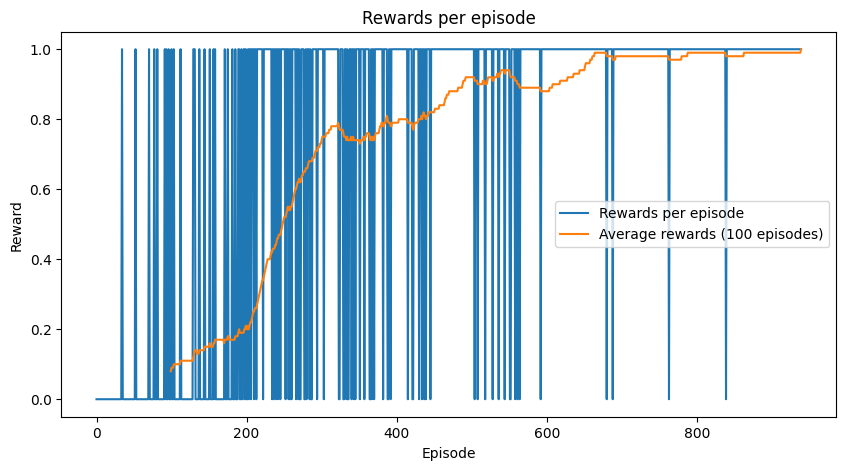

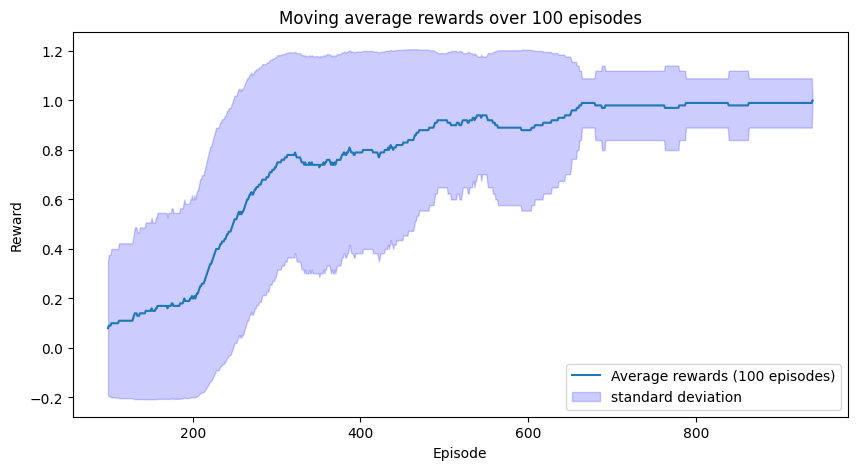

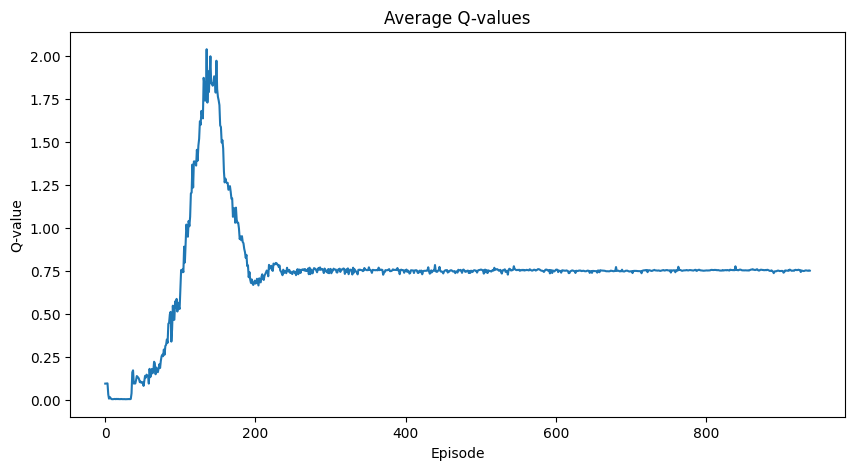

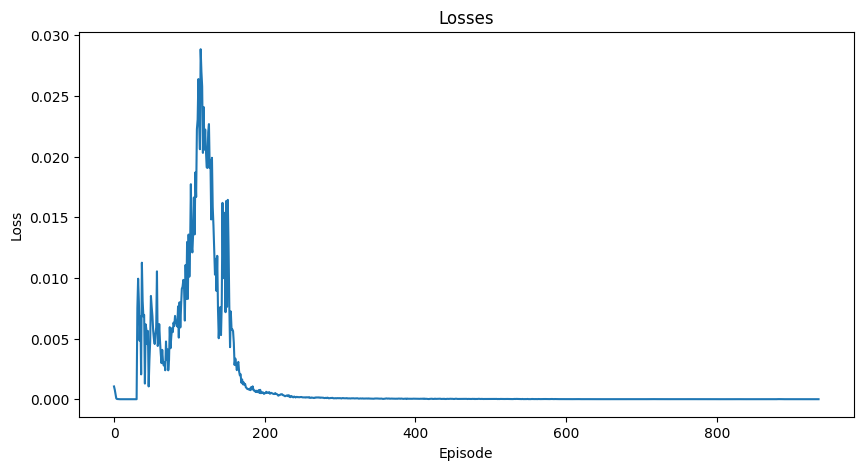

In [ ]:
plot_results(rewards,std_rewards, avg_rewards, q_values, losses, "Plots/FrozenLake_w_prioritized/")

100%|██████████| 100/100 [00:03<00:00, 33.17it/s]


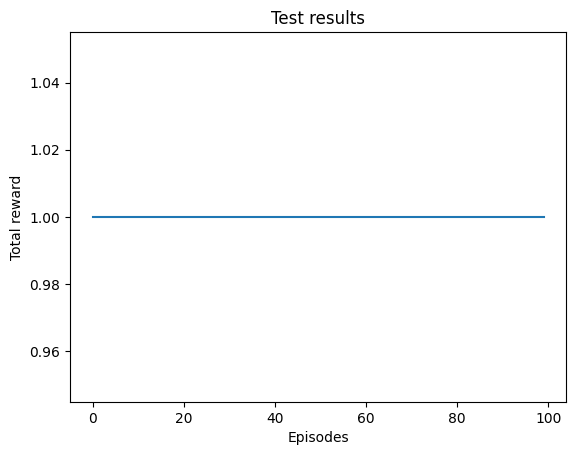

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [26]:
test(agent, "Plots/FrozenLake_w_prioritized/")

In [27]:
save_video(env, agent, "Videos/FrozenLake_w_prioritized.mp4")

1.0


# 6. Train CNN model on Frozen Lake (without prioritized)

In [16]:
# HYPERPARAMETERS
GAMMA = 0.95            # Facteur de discount
LR = 1e-4               # Taux d'apprentissage
BATCH_SIZE = 32         # Taille des lots pour l'entraînement
MEMORY_SIZE = 1000    # Taille du replay buffer
EPSILON_START = 1.0     # Valeur initiale pour epsilon (exploration)
EPSILON_END = 0.01      # Valeur finale pour epsilon
EPSILON_DECAY = 0.995   # Facteur de décroissance pour epsilon
TARGET_UPDATE = 10      # Fréquence de mise à jour du réseau cible
TAU = 0.1               # Taux de mise à jour du réseau cible
K = 100                 # Fenêtre pour calculer la moyenne des rewards
SUCCESS_THRESHOLD = 0.99 # Valeur de succès
NUM_EPISODES = 2000
TRAIN_FROM_FRAME = True
SOFT_UPDATE = True
STACK_SIZE = 4
ROWS = 84
COLS = 84

In [ ]:
# Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("FrozenLake-v1",map_name="4x4", is_slippery=False, render_mode="rgb_array")
fix_all_seeds(42, env)
_, _ = env.reset()

# state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(STACK_SIZE, action_size, CNNQNetwork, ReplayBuffer)

# Training
rewards,std_rewards, avg_rewards, q_values, losses = train_agent(env, agent)

# Save model
torch.save(agent.qnetwork_policy.state_dict(), 'Models/policy_cnn_frozen.pt')
torch.save(agent.qnetwork_target.state_dict(), 'Models/target_cnn_frozen.pt')

  5%|▌         | 101/2000 [00:17<07:18,  4.33it/s]

Episode 100/2000, Avg Reward (last 100): 0.01, Avg Q: 0.03, Epsilon: 0.61


 10%|█         | 200/2000 [00:34<06:08,  4.89it/s]

Episode 200/2000, Avg Reward (last 100): 0.26, Avg Q: 1.18, Epsilon: 0.37


 15%|█▌        | 301/2000 [00:49<03:37,  7.80it/s]

Episode 300/2000, Avg Reward (last 100): 0.61, Avg Q: 0.76, Epsilon: 0.22


 20%|██        | 401/2000 [01:01<03:21,  7.94it/s]

Episode 400/2000, Avg Reward (last 100): 0.83, Avg Q: 0.76, Epsilon: 0.13


 25%|██▌       | 501/2000 [01:13<02:56,  8.47it/s]

Episode 500/2000, Avg Reward (last 100): 0.92, Avg Q: 0.75, Epsilon: 0.08


 30%|███       | 601/2000 [01:25<02:52,  8.12it/s]

Episode 600/2000, Avg Reward (last 100): 0.94, Avg Q: 0.75, Epsilon: 0.05


 35%|███▌      | 701/2000 [01:37<02:29,  8.70it/s]

Episode 700/2000, Avg Reward (last 100): 0.96, Avg Q: 0.76, Epsilon: 0.03


 40%|████      | 801/2000 [01:49<02:25,  8.24it/s]

Episode 800/2000, Avg Reward (last 100): 0.98, Avg Q: 0.75, Epsilon: 0.02


 42%|████▏     | 843/2000 [01:55<02:38,  7.32it/s]

Environnement solved after 844 episode with an average reward of 1.00


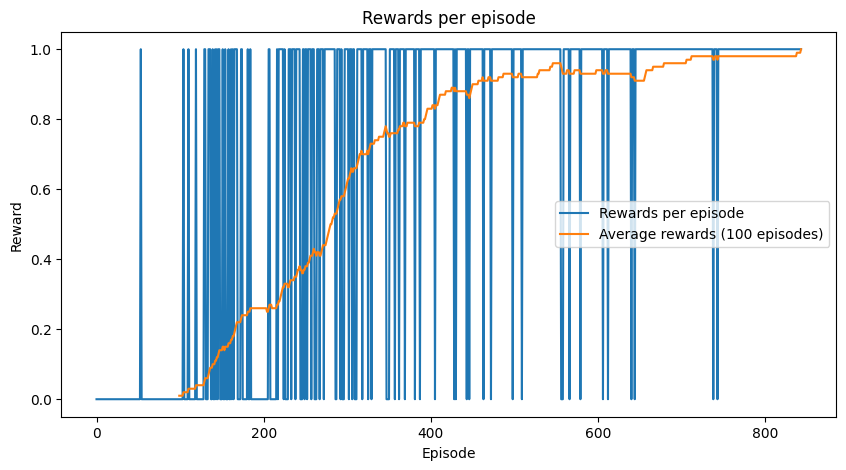

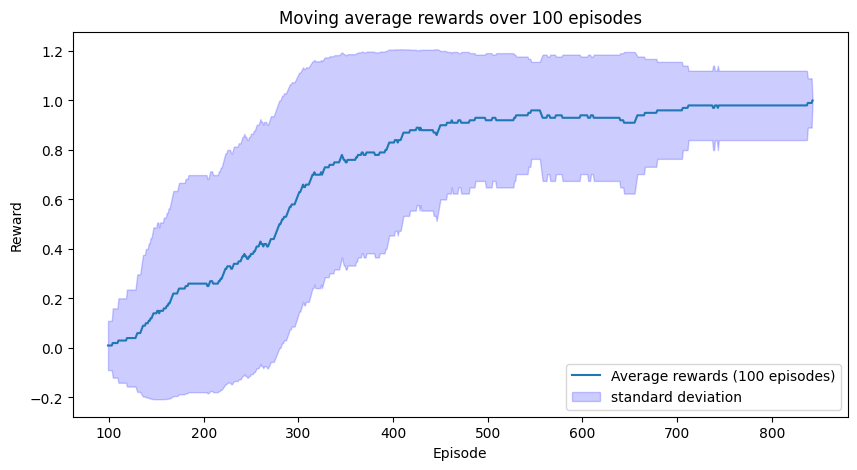

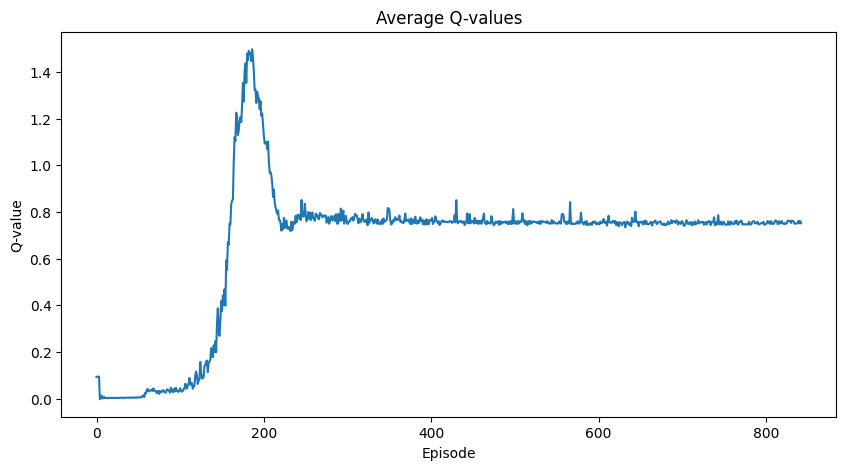

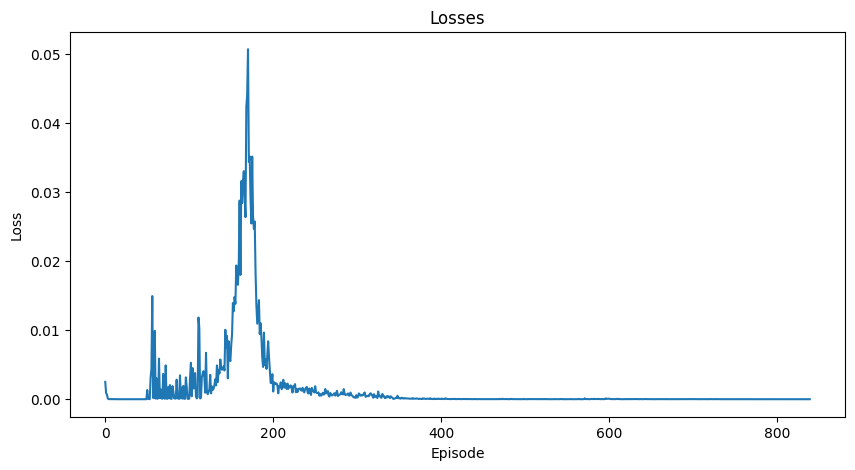

In [24]:
plot_results(rewards,std_rewards, avg_rewards, q_values, losses, "Plots/FrozenLake/")

100%|██████████| 100/100 [00:02<00:00, 41.98it/s]


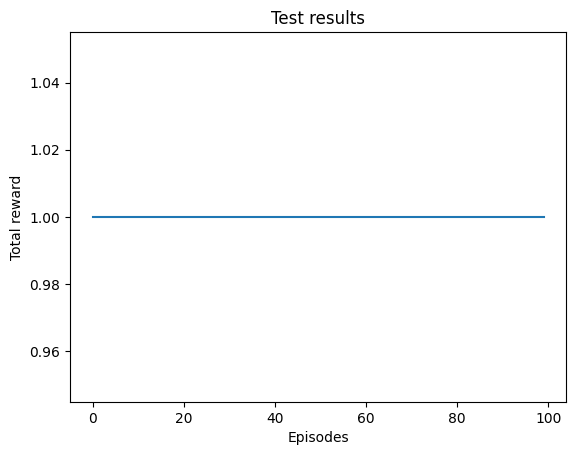

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [25]:
test(agent, "Plots/FrozenLake/")

In [26]:
save_video(env, agent, "Videos/FrozenLake.mp4")

1.0


# 7. Train CNN model on Lunar Lander

In [33]:
# HYPERPARAMETERS
GAMMA = 0.95            # Facteur de discount
LR = 1e-4               # Taux d'apprentissage
BATCH_SIZE = 32         # Taille des lots pour l'entraînement
MEMORY_SIZE = 10000    # Taille du replay buffer
EPSILON_START = 1.0     # Valeur initiale pour epsilon (exploration)
EPSILON_END = 0.01      # Valeur finale pour epsilon
EPSILON_DECAY = 0.9995   # Facteur de décroissance pour epsilon
TARGET_UPDATE = 10      # Fréquence de mise à jour du réseau cible
TAU = 0.1               # Taux de mise à jour du réseau cible
K = 100                 # Fenêtre pour calculer la moyenne des rewards
SUCCESS_THRESHOLD = 200 # Valeur de succès
NUM_EPISODES = 10000
TRAIN_FROM_FRAME = True
SOFT_UPDATE = True
STACK_SIZE = 4
ROWS = 84
COLS = 84

In [34]:
# Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("LunarLander-v3", render_mode="rgb_array")
fix_all_seeds(42, env)
_, _ = env.reset()

# state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(STACK_SIZE, action_size, CNNQNetwork, ReplayBuffer)

# Training
rewards,std_rewards, avg_rewards, q_values, losses = train_agent(env, agent)

# Save model
torch.save(agent.qnetwork_policy.state_dict(), 'Models/policy_cnn_lunar.pt')
torch.save(agent.qnetwork_target.state_dict(), 'Models/target_cnn_lunar.pt')

  0%|          | 0/10000 [00:00<?, ?it/s]

  1%|          | 100/10000 [04:02<7:16:16,  2.64s/it]

Episode 100/10000, Avg Reward (last 100): -178.66, Avg Q: -29.38, Epsilon: 0.95


  2%|▏         | 200/10000 [08:07<6:59:36,  2.57s/it]

Episode 200/10000, Avg Reward (last 100): -180.39, Avg Q: -59.69, Epsilon: 0.90


  3%|▎         | 300/10000 [12:30<6:17:08,  2.33s/it]

Episode 300/10000, Avg Reward (last 100): -176.33, Avg Q: -56.60, Epsilon: 0.86


  4%|▍         | 400/10000 [16:47<6:49:14,  2.56s/it]

Episode 400/10000, Avg Reward (last 100): -210.61, Avg Q: -63.61, Epsilon: 0.82


  5%|▌         | 500/10000 [21:13<6:33:58,  2.49s/it]

Episode 500/10000, Avg Reward (last 100): -195.93, Avg Q: -47.50, Epsilon: 0.78


  6%|▌         | 600/10000 [25:37<6:47:02,  2.60s/it]

Episode 600/10000, Avg Reward (last 100): -206.19, Avg Q: -57.35, Epsilon: 0.74


  7%|▋         | 700/10000 [30:10<6:40:10,  2.58s/it]

Episode 700/10000, Avg Reward (last 100): -202.30, Avg Q: -43.53, Epsilon: 0.70


  8%|▊         | 800/10000 [34:49<6:15:43,  2.45s/it]

Episode 800/10000, Avg Reward (last 100): -204.64, Avg Q: -63.95, Epsilon: 0.67


  9%|▉         | 900/10000 [39:30<8:39:40,  3.43s/it]

Episode 900/10000, Avg Reward (last 100): -249.81, Avg Q: -104.42, Epsilon: 0.64


 10%|█         | 1000/10000 [44:24<7:15:38,  2.90s/it]

Episode 1000/10000, Avg Reward (last 100): -240.39, Avg Q: -53.27, Epsilon: 0.61


 11%|█         | 1100/10000 [49:34<6:40:47,  2.70s/it] 

Episode 1100/10000, Avg Reward (last 100): -238.34, Avg Q: -103.03, Epsilon: 0.58


 12%|█▏        | 1200/10000 [54:25<6:47:18,  2.78s/it]

Episode 1200/10000, Avg Reward (last 100): -261.42, Avg Q: -63.33, Epsilon: 0.55


 13%|█▎        | 1300/10000 [59:21<6:21:02,  2.63s/it] 

Episode 1300/10000, Avg Reward (last 100): -258.63, Avg Q: -69.11, Epsilon: 0.52


 14%|█▍        | 1400/10000 [1:04:18<7:00:10,  2.93s/it] 

Episode 1400/10000, Avg Reward (last 100): -253.28, Avg Q: -124.08, Epsilon: 0.50


 15%|█▌        | 1500/10000 [1:09:19<5:50:57,  2.48s/it] 

Episode 1500/10000, Avg Reward (last 100): -277.29, Avg Q: -106.56, Epsilon: 0.47


 16%|█▌        | 1600/10000 [1:13:53<6:32:21,  2.80s/it]

Episode 1600/10000, Avg Reward (last 100): -261.86, Avg Q: -97.08, Epsilon: 0.45


 17%|█▋        | 1700/10000 [1:18:50<5:53:49,  2.56s/it]

Episode 1700/10000, Avg Reward (last 100): -293.04, Avg Q: -67.15, Epsilon: 0.43


 18%|█▊        | 1800/10000 [1:23:43<6:57:10,  3.05s/it] 

Episode 1800/10000, Avg Reward (last 100): -285.86, Avg Q: -132.50, Epsilon: 0.41


 19%|█▉        | 1900/10000 [1:28:35<6:31:09,  2.90s/it]

Episode 1900/10000, Avg Reward (last 100): -277.06, Avg Q: -121.69, Epsilon: 0.39


 20%|██        | 2000/10000 [1:33:30<6:35:07,  2.96s/it] 

Episode 2000/10000, Avg Reward (last 100): -276.23, Avg Q: -60.46, Epsilon: 0.37


 21%|██        | 2100/10000 [1:38:17<6:18:26,  2.87s/it]

Episode 2100/10000, Avg Reward (last 100): -277.84, Avg Q: -101.87, Epsilon: 0.35


 22%|██▏       | 2200/10000 [1:42:43<5:20:08,  2.46s/it]

Episode 2200/10000, Avg Reward (last 100): -286.74, Avg Q: -64.97, Epsilon: 0.33


 23%|██▎       | 2300/10000 [1:46:56<6:26:59,  3.02s/it]

Episode 2300/10000, Avg Reward (last 100): -266.20, Avg Q: -93.69, Epsilon: 0.32


 24%|██▍       | 2400/10000 [1:51:07<5:29:36,  2.60s/it]

Episode 2400/10000, Avg Reward (last 100): -261.88, Avg Q: -156.82, Epsilon: 0.30


 25%|██▌       | 2500/10000 [1:55:18<5:10:28,  2.48s/it]

Episode 2500/10000, Avg Reward (last 100): -291.90, Avg Q: -96.32, Epsilon: 0.29


 26%|██▌       | 2600/10000 [1:59:28<4:51:25,  2.36s/it]

Episode 2600/10000, Avg Reward (last 100): -261.00, Avg Q: -117.29, Epsilon: 0.27


 27%|██▋       | 2700/10000 [2:03:30<3:48:03,  1.87s/it]

Episode 2700/10000, Avg Reward (last 100): -274.47, Avg Q: -103.20, Epsilon: 0.26


 28%|██▊       | 2800/10000 [2:08:02<4:05:06,  2.04s/it] 

Episode 2800/10000, Avg Reward (last 100): -277.82, Avg Q: -50.17, Epsilon: 0.25


 29%|██▉       | 2900/10000 [2:12:23<6:13:06,  3.15s/it]

Episode 2900/10000, Avg Reward (last 100): -290.71, Avg Q: -51.84, Epsilon: 0.23


 30%|███       | 3000/10000 [2:16:30<4:11:35,  2.16s/it]

Episode 3000/10000, Avg Reward (last 100): -254.89, Avg Q: -69.02, Epsilon: 0.22


 31%|███       | 3100/10000 [2:20:58<5:56:41,  3.10s/it]

Episode 3100/10000, Avg Reward (last 100): -265.02, Avg Q: -78.11, Epsilon: 0.21


 32%|███▏      | 3200/10000 [2:25:04<5:30:02,  2.91s/it]

Episode 3200/10000, Avg Reward (last 100): -275.79, Avg Q: -100.25, Epsilon: 0.20


 33%|███▎      | 3300/10000 [2:29:11<4:24:31,  2.37s/it]

Episode 3300/10000, Avg Reward (last 100): -243.77, Avg Q: -112.00, Epsilon: 0.19


 34%|███▍      | 3400/10000 [2:33:14<4:54:58,  2.68s/it]

Episode 3400/10000, Avg Reward (last 100): -255.59, Avg Q: -99.89, Epsilon: 0.18


 35%|███▌      | 3500/10000 [2:37:33<5:14:53,  2.91s/it]

Episode 3500/10000, Avg Reward (last 100): -251.72, Avg Q: -99.00, Epsilon: 0.17


 36%|███▌      | 3600/10000 [2:41:28<4:01:16,  2.26s/it]

Episode 3600/10000, Avg Reward (last 100): -265.99, Avg Q: -94.24, Epsilon: 0.17


 37%|███▋      | 3700/10000 [2:45:39<5:33:35,  3.18s/it]

Episode 3700/10000, Avg Reward (last 100): -260.42, Avg Q: -121.23, Epsilon: 0.16


 38%|███▊      | 3800/10000 [2:50:05<3:50:59,  2.24s/it]

Episode 3800/10000, Avg Reward (last 100): -262.20, Avg Q: -82.28, Epsilon: 0.15


 39%|███▉      | 3900/10000 [2:54:17<3:31:46,  2.08s/it]

Episode 3900/10000, Avg Reward (last 100): -235.71, Avg Q: -57.09, Epsilon: 0.14


 40%|████      | 4000/10000 [2:58:28<4:26:12,  2.66s/it]

Episode 4000/10000, Avg Reward (last 100): -232.37, Avg Q: -82.02, Epsilon: 0.14


 41%|████      | 4100/10000 [3:02:43<5:07:05,  3.12s/it]

Episode 4100/10000, Avg Reward (last 100): -248.68, Avg Q: -87.66, Epsilon: 0.13


 42%|████▏     | 4200/10000 [3:06:55<4:18:17,  2.67s/it]

Episode 4200/10000, Avg Reward (last 100): -270.52, Avg Q: -54.10, Epsilon: 0.12


 43%|████▎     | 4300/10000 [3:11:18<4:16:59,  2.71s/it]

Episode 4300/10000, Avg Reward (last 100): -237.74, Avg Q: -131.82, Epsilon: 0.12


 44%|████▍     | 4400/10000 [3:15:45<3:28:16,  2.23s/it]

Episode 4400/10000, Avg Reward (last 100): -263.80, Avg Q: -85.41, Epsilon: 0.11


 45%|████▌     | 4500/10000 [3:20:16<4:06:09,  2.69s/it]

Episode 4500/10000, Avg Reward (last 100): -264.03, Avg Q: -114.44, Epsilon: 0.11


 46%|████▌     | 4600/10000 [3:24:58<4:58:57,  3.32s/it]

Episode 4600/10000, Avg Reward (last 100): -243.45, Avg Q: -115.53, Epsilon: 0.10


 47%|████▋     | 4700/10000 [3:29:10<3:30:02,  2.38s/it]

Episode 4700/10000, Avg Reward (last 100): -247.16, Avg Q: -106.57, Epsilon: 0.10


 48%|████▊     | 4800/10000 [3:33:28<4:12:06,  2.91s/it]

Episode 4800/10000, Avg Reward (last 100): -228.42, Avg Q: -49.77, Epsilon: 0.09


 49%|████▉     | 4900/10000 [3:37:59<3:13:29,  2.28s/it]

Episode 4900/10000, Avg Reward (last 100): -227.85, Avg Q: -60.37, Epsilon: 0.09


 50%|█████     | 5000/10000 [3:42:08<2:58:24,  2.14s/it]

Episode 5000/10000, Avg Reward (last 100): -242.95, Avg Q: -119.57, Epsilon: 0.08


 51%|█████     | 5100/10000 [3:46:34<3:27:37,  2.54s/it]

Episode 5100/10000, Avg Reward (last 100): -257.10, Avg Q: -99.79, Epsilon: 0.08


 52%|█████▏    | 5200/10000 [3:51:09<2:56:27,  2.21s/it]

Episode 5200/10000, Avg Reward (last 100): -258.38, Avg Q: -100.39, Epsilon: 0.07


 53%|█████▎    | 5300/10000 [3:55:22<3:13:35,  2.47s/it]

Episode 5300/10000, Avg Reward (last 100): -272.93, Avg Q: -91.03, Epsilon: 0.07


 54%|█████▍    | 5400/10000 [3:59:46<2:56:02,  2.30s/it]

Episode 5400/10000, Avg Reward (last 100): -270.51, Avg Q: -93.62, Epsilon: 0.07


 55%|█████▌    | 5500/10000 [4:03:37<3:29:39,  2.80s/it]

Episode 5500/10000, Avg Reward (last 100): -303.51, Avg Q: -100.60, Epsilon: 0.06


 56%|█████▌    | 5600/10000 [4:07:39<2:39:52,  2.18s/it]

Episode 5600/10000, Avg Reward (last 100): -307.17, Avg Q: -94.20, Epsilon: 0.06


 57%|█████▋    | 5700/10000 [4:11:27<3:00:24,  2.52s/it]

Episode 5700/10000, Avg Reward (last 100): -250.52, Avg Q: -26.95, Epsilon: 0.06


 58%|█████▊    | 5800/10000 [4:15:28<2:35:32,  2.22s/it]

Episode 5800/10000, Avg Reward (last 100): -279.98, Avg Q: -74.24, Epsilon: 0.05


 59%|█████▉    | 5900/10000 [4:19:29<2:24:05,  2.11s/it]

Episode 5900/10000, Avg Reward (last 100): -248.58, Avg Q: -62.22, Epsilon: 0.05


 60%|██████    | 6000/10000 [4:23:31<2:31:40,  2.28s/it]

Episode 6000/10000, Avg Reward (last 100): -241.31, Avg Q: -119.81, Epsilon: 0.05


 61%|██████    | 6100/10000 [4:27:22<2:31:49,  2.34s/it]

Episode 6100/10000, Avg Reward (last 100): -203.05, Avg Q: -102.64, Epsilon: 0.05


 62%|██████▏   | 6200/10000 [4:31:18<2:26:08,  2.31s/it]

Episode 6200/10000, Avg Reward (last 100): -246.80, Avg Q: -145.38, Epsilon: 0.05


 63%|██████▎   | 6300/10000 [4:35:18<2:23:54,  2.33s/it]

Episode 6300/10000, Avg Reward (last 100): -215.42, Avg Q: -73.29, Epsilon: 0.04


 64%|██████▍   | 6400/10000 [4:39:12<2:44:20,  2.74s/it]

Episode 6400/10000, Avg Reward (last 100): -197.16, Avg Q: -102.56, Epsilon: 0.04


 65%|██████▌   | 6500/10000 [4:42:59<2:01:43,  2.09s/it]

Episode 6500/10000, Avg Reward (last 100): -214.25, Avg Q: -90.89, Epsilon: 0.04


 66%|██████▌   | 6600/10000 [4:46:47<1:59:23,  2.11s/it]

Episode 6600/10000, Avg Reward (last 100): -225.12, Avg Q: -69.47, Epsilon: 0.04


 67%|██████▋   | 6700/10000 [4:50:45<1:57:29,  2.14s/it]

Episode 6700/10000, Avg Reward (last 100): -194.11, Avg Q: -67.63, Epsilon: 0.04


 68%|██████▊   | 6800/10000 [4:54:30<1:48:15,  2.03s/it]

Episode 6800/10000, Avg Reward (last 100): -186.78, Avg Q: -90.22, Epsilon: 0.03


 69%|██████▉   | 6900/10000 [4:58:43<2:15:24,  2.62s/it]

Episode 6900/10000, Avg Reward (last 100): -206.38, Avg Q: -100.64, Epsilon: 0.03


 70%|███████   | 7000/10000 [5:02:47<2:05:42,  2.51s/it]

Episode 7000/10000, Avg Reward (last 100): -215.13, Avg Q: -89.85, Epsilon: 0.03


 71%|███████   | 7100/10000 [5:06:52<1:57:56,  2.44s/it]

Episode 7100/10000, Avg Reward (last 100): -207.55, Avg Q: -78.24, Epsilon: 0.03


 72%|███████▏  | 7200/10000 [5:11:09<1:48:16,  2.32s/it]

Episode 7200/10000, Avg Reward (last 100): -214.13, Avg Q: -75.16, Epsilon: 0.03


 73%|███████▎  | 7300/10000 [5:15:30<1:53:59,  2.53s/it]

Episode 7300/10000, Avg Reward (last 100): -263.72, Avg Q: -95.96, Epsilon: 0.03


 74%|███████▍  | 7400/10000 [5:19:53<1:32:57,  2.15s/it]

Episode 7400/10000, Avg Reward (last 100): -228.90, Avg Q: -133.80, Epsilon: 0.02


 75%|███████▌  | 7500/10000 [5:24:01<2:01:11,  2.91s/it]

Episode 7500/10000, Avg Reward (last 100): -198.54, Avg Q: -121.93, Epsilon: 0.02


 76%|███████▌  | 7600/10000 [5:27:49<1:24:21,  2.11s/it]

Episode 7600/10000, Avg Reward (last 100): -204.01, Avg Q: -115.01, Epsilon: 0.02


 77%|███████▋  | 7700/10000 [5:31:53<1:38:55,  2.58s/it]

Episode 7700/10000, Avg Reward (last 100): -208.56, Avg Q: -111.34, Epsilon: 0.02


 78%|███████▊  | 7800/10000 [5:36:01<1:25:05,  2.32s/it]

Episode 7800/10000, Avg Reward (last 100): -216.61, Avg Q: -132.66, Epsilon: 0.02


 79%|███████▉  | 7900/10000 [5:40:13<1:25:11,  2.43s/it]

Episode 7900/10000, Avg Reward (last 100): -233.98, Avg Q: -97.24, Epsilon: 0.02


 80%|████████  | 8000/10000 [5:44:31<1:18:18,  2.35s/it]

Episode 8000/10000, Avg Reward (last 100): -214.54, Avg Q: -61.47, Epsilon: 0.02


 81%|████████  | 8100/10000 [5:48:54<1:21:15,  2.57s/it]

Episode 8100/10000, Avg Reward (last 100): -191.66, Avg Q: -87.82, Epsilon: 0.02


 82%|████████▏ | 8200/10000 [5:53:36<1:31:58,  3.07s/it]

Episode 8200/10000, Avg Reward (last 100): -226.69, Avg Q: -34.86, Epsilon: 0.02


 83%|████████▎ | 8300/10000 [5:58:09<1:25:50,  3.03s/it]

Episode 8300/10000, Avg Reward (last 100): -202.62, Avg Q: -104.38, Epsilon: 0.02


 84%|████████▍ | 8400/10000 [6:02:49<1:09:18,  2.60s/it]

Episode 8400/10000, Avg Reward (last 100): -199.97, Avg Q: -78.99, Epsilon: 0.01


 85%|████████▌ | 8500/10000 [6:07:16<1:23:31,  3.34s/it]

Episode 8500/10000, Avg Reward (last 100): -177.10, Avg Q: -52.61, Epsilon: 0.01


 86%|████████▌ | 8600/10000 [6:11:38<51:38,  2.21s/it]  

Episode 8600/10000, Avg Reward (last 100): -244.89, Avg Q: -68.12, Epsilon: 0.01


 87%|████████▋ | 8700/10000 [6:16:14<52:00,  2.40s/it]  

Episode 8700/10000, Avg Reward (last 100): -195.23, Avg Q: -103.85, Epsilon: 0.01


 88%|████████▊ | 8800/10000 [6:20:34<45:10,  2.26s/it]  

Episode 8800/10000, Avg Reward (last 100): -206.35, Avg Q: -63.17, Epsilon: 0.01


 89%|████████▉ | 8900/10000 [6:25:05<44:54,  2.45s/it]  

Episode 8900/10000, Avg Reward (last 100): -241.51, Avg Q: -99.05, Epsilon: 0.01


 90%|█████████ | 9000/10000 [6:29:19<48:54,  2.93s/it]

Episode 9000/10000, Avg Reward (last 100): -220.59, Avg Q: -86.82, Epsilon: 0.01


 91%|█████████ | 9100/10000 [6:33:29<37:21,  2.49s/it]

Episode 9100/10000, Avg Reward (last 100): -227.08, Avg Q: -89.35, Epsilon: 0.01


 92%|█████████▏| 9200/10000 [6:38:10<29:37,  2.22s/it]

Episode 9200/10000, Avg Reward (last 100): -223.74, Avg Q: -141.03, Epsilon: 0.01


 93%|█████████▎| 9300/10000 [6:42:51<33:11,  2.84s/it]

Episode 9300/10000, Avg Reward (last 100): -228.71, Avg Q: -80.38, Epsilon: 0.01


 94%|█████████▍| 9400/10000 [6:47:41<30:17,  3.03s/it]

Episode 9400/10000, Avg Reward (last 100): -232.96, Avg Q: -121.22, Epsilon: 0.01


 95%|█████████▌| 9500/10000 [6:52:42<28:06,  3.37s/it]

Episode 9500/10000, Avg Reward (last 100): -248.91, Avg Q: -83.79, Epsilon: 0.01


 96%|█████████▌| 9600/10000 [6:57:33<23:17,  3.49s/it]

Episode 9600/10000, Avg Reward (last 100): -241.88, Avg Q: -92.05, Epsilon: 0.01


 97%|█████████▋| 9700/10000 [7:02:08<12:25,  2.48s/it]

Episode 9700/10000, Avg Reward (last 100): -216.08, Avg Q: -99.23, Epsilon: 0.01


 98%|█████████▊| 9800/10000 [7:06:50<10:54,  3.27s/it]

Episode 9800/10000, Avg Reward (last 100): -247.38, Avg Q: -127.40, Epsilon: 0.01


 99%|█████████▉| 9900/10000 [7:11:32<04:06,  2.46s/it]

Episode 9900/10000, Avg Reward (last 100): -241.13, Avg Q: -88.27, Epsilon: 0.01


100%|██████████| 10000/10000 [7:16:26<00:00,  2.62s/it]


Episode 10000/10000, Avg Reward (last 100): -233.97, Avg Q: -76.38, Epsilon: 0.01


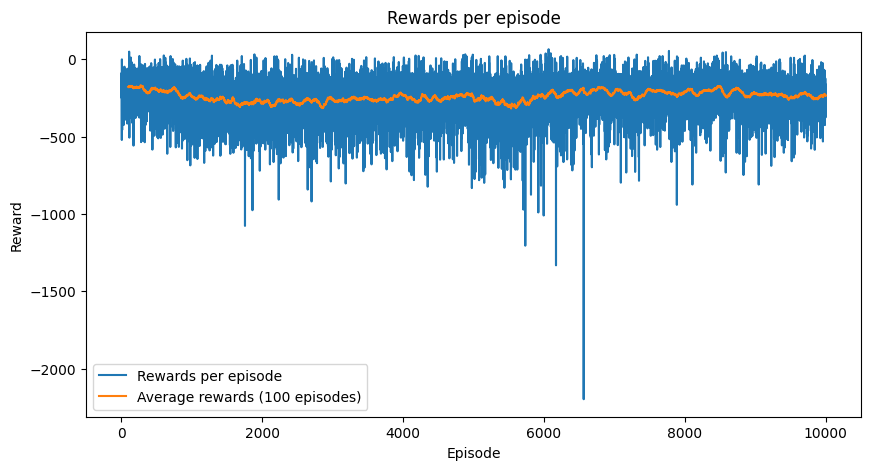

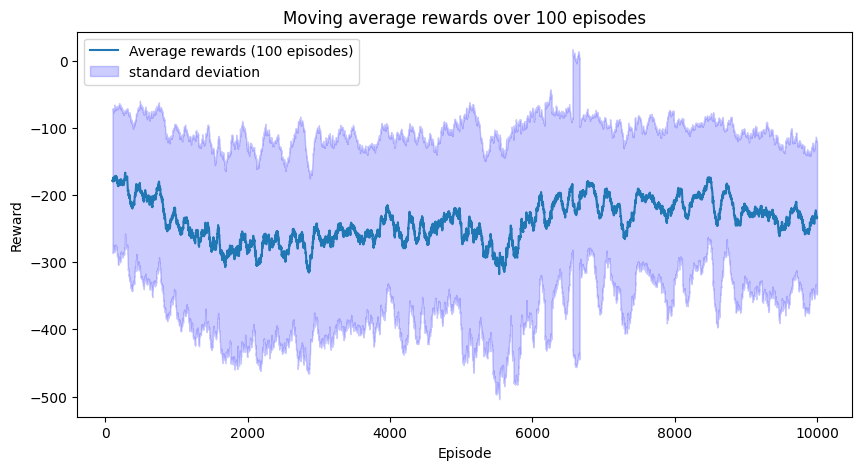

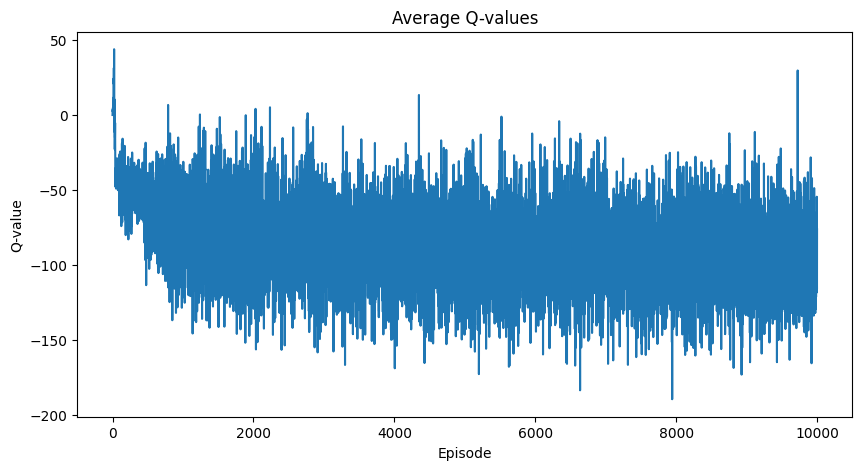

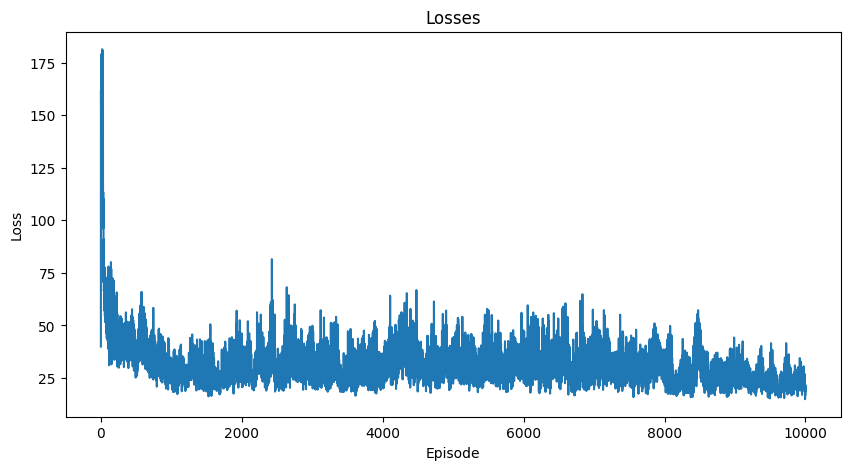

In [35]:
plot_results(rewards,std_rewards, avg_rewards, q_values, losses, "Plots/CNN_Lunar/")

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


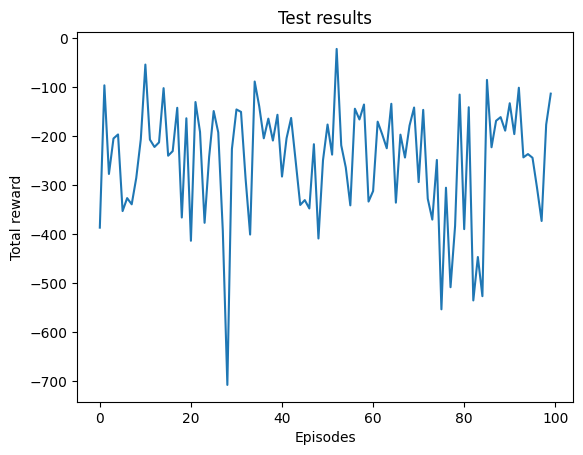

[np.float64(-386.77614526993574), np.float64(-96.32875720297505), np.float64(-277.2162279170841), np.float64(-204.82896703960836), np.float64(-196.59906059129924), np.float64(-353.00299402238466), np.float64(-326.4933213476504), np.float64(-339.17997109085), np.float64(-285.21630974559685), np.float64(-206.14206396791587), np.float64(-53.98709219980148), np.float64(-207.13060984967632), np.float64(-222.1234146488272), np.float64(-212.78668578490584), np.float64(-102.09704980030051), np.float64(-239.9660785009663), np.float64(-230.62023427612667), np.float64(-142.1800789953849), np.float64(-366.1267880183462), np.float64(-163.58867611005644), np.float64(-413.5805862690589), np.float64(-130.42765206990572), np.float64(-191.46073163251307), np.float64(-376.9314263551231), np.float64(-242.41179032235632), np.float64(-148.84614229765486), np.float64(-192.45130940364356), np.float64(-392.8714847089843), np.float64(-707.7620394730806), np.float64(-226.36563997752597), np.float64(-145.58132258

In [36]:
test(agent)

In [37]:
save_video(env, agent, "Videos/LunarLander_CNN.mp4")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


-181.91216044346186
